In [1]:
from mltoolbox.basic import *

In [2]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]
%matplotlib inline

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from PIL import Image
from sklearn.preprocessing import LabelBinarizer
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision import models, datasets, transforms

from pathlib import Path
import math, os

In [4]:
PATH = Path("data/train_sp/")
len(list(PATH.iterdir()))

8712

In [5]:
from mltoolbox.plotting import *

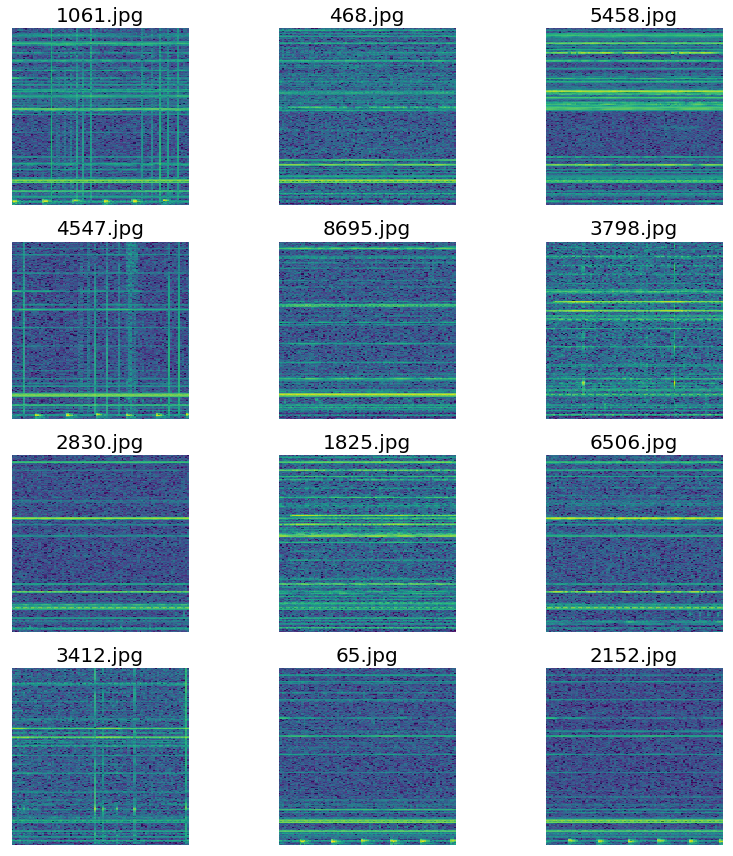

In [6]:
rand_files = [f'data/train_sp/{i}.jpg' for i in np.random.randint(0, 8712, 12)]
multi_plot(rand_files)

In [6]:
sz=500

In [7]:
train_meta = pd.read_csv('data/metadata_train.csv')
train_meta['fname'] =  train_meta.signal_id.apply(lambda x: f"data/train_sp/{x}.jpg")
faulty_lines = train_meta.id_measurement[train_meta.target == 1].unique()
train_meta['is_faulty'] = train_meta.id_measurement.apply(lambda x: x in faulty_lines)
no_faulty_lines = train_meta.id_measurement[train_meta.is_faulty == False].unique()

In [8]:
faulty_lines.shape

(194,)

In [9]:
no_faulty_lines.shape

(2710,)

In [10]:
train_faulty_lines = np.random.choice(faulty_lines, int(0.9 * 194), replace=False)
train_no_faulty_lines = np.random.choice(no_faulty_lines, int(0.9 * 2710), replace=False)

In [11]:
train_meta['is_train'] = train_meta.id_measurement.isin((train_no_faulty_lines.tolist() +
                                                         train_faulty_lines.tolist()))

In [12]:
train_meta.is_train.value_counts()

True     7839
False     873
Name: is_train, dtype: int64

In [13]:
train = train_meta[train_meta.is_train == True].copy()
valid = train_meta[train_meta.is_train == False].copy()

In [14]:
train.shape

(7839, 7)

In [15]:
valid.shape

(873, 7)

In [16]:
train.target.value_counts()

0    7368
1     471
Name: target, dtype: int64

In [17]:
valid.target.value_counts()

0    819
1     54
Name: target, dtype: int64

In [18]:
train = balance_dataset(train, target_col='target', alpha=0.2)

In [19]:
train.target.value_counts()

0    7368
1    1884
Name: target, dtype: int64

In [7]:
from mltoolbox.image import *

In [8]:
class SpectrogramDataset(Dataset):
    def __init__(self, df, is_valid=False, is_test=False):
        self.num_files = df.shape[0]
        self.file_path = df.fname.values
        if not is_test:
            self.labels = df.target.values
        self.is_valid = is_valid
        self.is_test = is_test
        self.id = df.signal_id

    def __len__(self):
        return self.num_files

    def __getitem__(self, idx):
        if not self.is_test:
            y = self.labels[idx]
        else:
            y = self.id[idx]
        fpath = str(self.file_path[idx])
        x = imread_fast(fpath)
        if not self.is_valid:
            x = hcyclic_shift(x, alpha=0.9, no_blocks=91)
        x = im_int2float(x)
        x = normalize_image(x)
        x =  np.rollaxis(x, 2)
        return x, y

In [22]:
train_ds = SpectrogramDataset(train)
valid_ds = SpectrogramDataset(valid, is_valid=True)

In [23]:
batch_size = 64

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [24]:
resnet = models.resnet34(pretrained=True)

In [9]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        resnet = models.resnet34(pretrained=True)
        # freezing parameters
        for param in resnet.parameters():
            param.requires_grad = False
        # convolutional layers of resnet34
        layers = list(resnet.children())[:8]
        self.top_model = nn.Sequential(*layers).cuda()
        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(512)
        self.fc1 = nn.Linear(512, 512)
        self.fc2 = nn.Linear(512, 1)
    
    def forward(self, x):
        x = F.relu(self.top_model(x))
        x = nn.AdaptiveAvgPool2d((1,1))(x)
        x = x.view(x.shape[0], -1) # flattening 
        x = nn.Dropout(0.3)(x)
        x = self.bn1(x)
        x = F.relu(self.fc1(x))
        x = nn.Dropout(0.3)(x)
        x = self.bn2(x)
        x = self.fc2(x)
        return x

In [10]:
model = Net().cuda()

In [27]:
x, y = next(iter(valid_dl))

In [29]:
y_hat = model(x.cuda().float())
y_hat.shape

torch.Size([64, 1])

In [30]:
y

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [11]:
loss_criteria = F.binary_cross_entropy_with_logits

In [12]:
from mltoolbox.dl import *

In [30]:
plt.rcParams['figure.figsize'] = [15.0, 6.0]

In [34]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

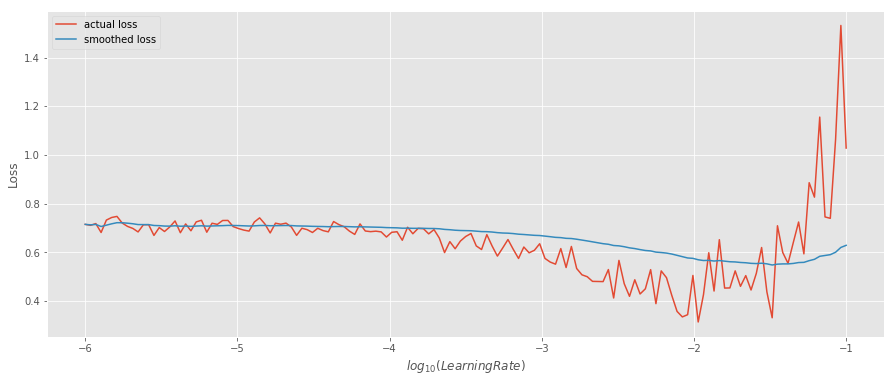

In [35]:
plot_lr(log_lrs, losses, smooth_losses)

In [31]:
best_lr = 10**(-2.5)
best_lr

0.0031622776601683794

In [32]:
batch_size = 64
train_dl = DataLoader(train_ds, batch_size=batch_size, num_workers=8, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

model = Net().cuda()

In [14]:
from sklearn.metrics import matthews_corrcoef, accuracy_score

In [39]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.6187345560337123,
 'accuracy_score': 0.9186712485681557,
 'matthews_corrcoef': -0.011285796869415183}

In [34]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.003, epochs=1)

Epoch No.:1, Train loss: 0.4453, val_loss: 0.2417, accuracy_score: 0.9118, matthews_corrcoef: 0.2466, 
train_triangular_policy 225.81 s


In [35]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=0.003, epochs=1)

Epoch No.:1, Train loss: 0.3627, val_loss: 0.2538, accuracy_score: 0.8889, matthews_corrcoef: 0.2293, 
train_triangular_policy 226.85 s


In [36]:
save_model(model, 'models/frozen.mdl')

In [37]:
load_model(model, 'models/frozen.mdl')

In [38]:
unfreeze(model, 7)

In [39]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

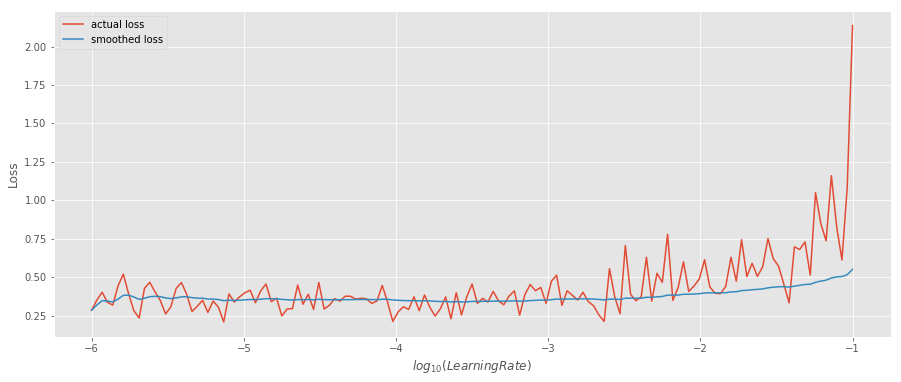

In [40]:
plot_lr(log_lrs, losses, smooth_losses)

In [41]:
batch_size = 60

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [42]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3), epochs=1)

Epoch No.:1, Train loss: 0.2926, val_loss: 0.1653, accuracy_score: 0.9198, matthews_corrcoef: 0.3867, 
train_triangular_policy 278.11 s


In [45]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-3.5), epochs=1)

Epoch No.:1, Train loss: 0.1630, val_loss: 0.1767, accuracy_score: 0.9313, matthews_corrcoef: 0.4662, 
train_triangular_policy 277.22 s


In [46]:
save_model(model, 'models/unfreeze1.mdl')

In [22]:
load_model(model, 'models/unfreeze1.mdl')

In [47]:
val_metrics(model=model, valid_dl=valid_dl,
            metrics=[accuracy_score, matthews_corrcoef], loss_criteria=loss_criteria)

{'val_loss': 0.18147225570432918,
 'accuracy_score': 0.9255441008018328,
 'matthews_corrcoef': 0.4261496253913889}

In [48]:
unfreeze(model, 6)

In [49]:
batch_size = 48

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=8)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, num_workers=8)

In [50]:
log_lrs, losses, smooth_losses = lr_range_finder(model, train_dl, lr_low=1e-6,
                                                 lr_high=0.1, loss_criteria=loss_criteria,
                                                 epochs=1)

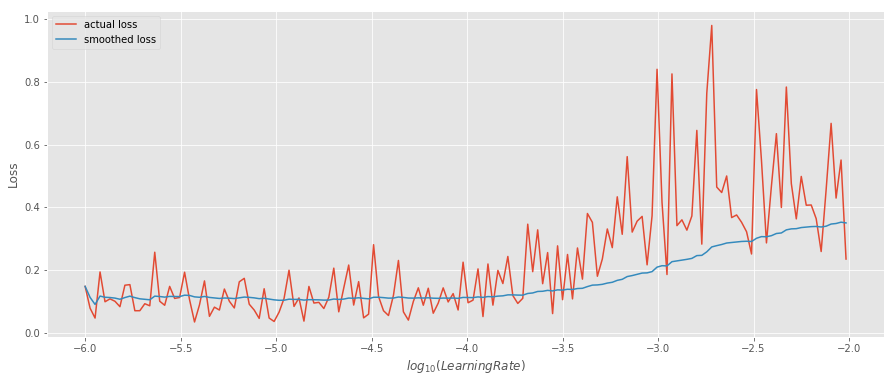

In [51]:
plot_lr(log_lrs, losses, smooth_losses)

In [54]:
training_loop(model=model, train_dl=train_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-4), epochs=1)

Epoch No.:1, Train loss: 0.1070, val_loss: 0.1778, accuracy_score: 0.9324, matthews_corrcoef: 0.3812, 
train_triangular_policy 242.77 s


In [13]:
from sklearn.metrics import confusion_matrix
from mltoolbox.plotting import plot_confusion_matrix

total_ds = SpectrogramDataset(train_meta)

In [56]:
batch_size = 48
total_dl = DataLoader(total_ds, batch_size=batch_size, shuffle=True, num_workers=8)

NameError: name 'total_ds' is not defined

In [90]:
training_loop(model=model, train_dl=total_dl, valid_dl=valid_dl, steps=1,
              loss_criteria=loss_criteria, metrics=[accuracy_score, matthews_corrcoef],
              lr_high=10**(-5), epochs=1)

Epoch No.:1, Train loss: 0.1983, val_loss: 0.1910, accuracy_score: 0.9381, matthews_corrcoef: 0.5535, 
train_triangular_policy 238.80 s


In [91]:
save_model(model, 'models/final1.mdl')

# predictions

In [15]:
test = pd.read_csv('data/metadata_test.csv')

In [16]:
test.head()

,signal_id,id_measurement,phase
0,8712,2904,0
1,8713,2904,1
2,8714,2904,2
3,8715,2905,0
4,8716,2905,1


In [18]:
test['fname'] = test.signal_id.apply(lambda x: f"data/test_sp/{x}.jpg")

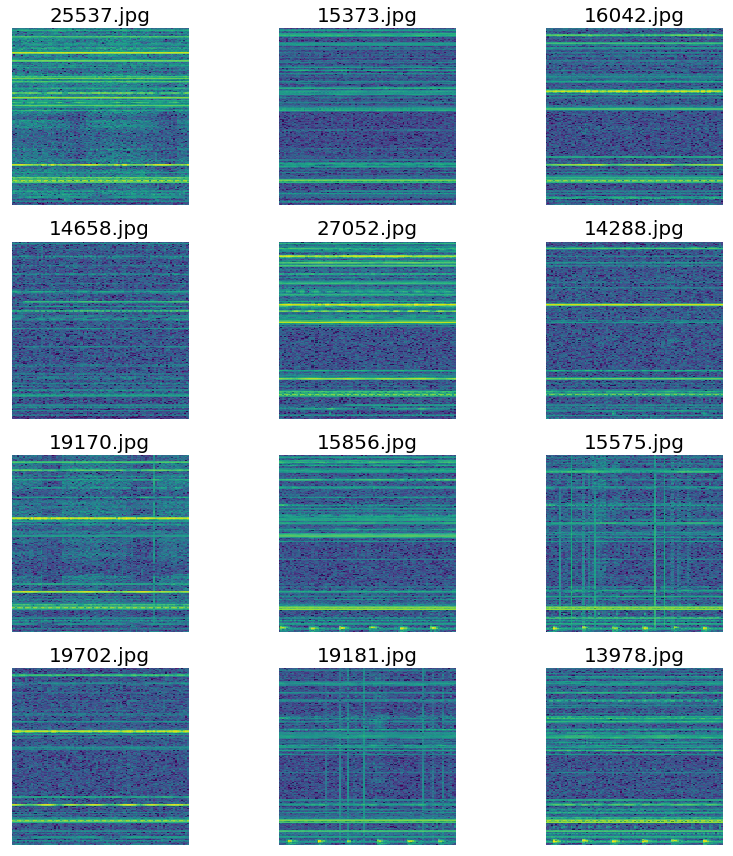

In [19]:
multi_plot(test.fname.sample(n=12).values)

In [20]:
test_ds = SpectrogramDataset(test, is_valid=True, is_test=True)

In [65]:
for i in progress_bar(range(8712, 29049)):
    try:
        im = imread_fast(f'data/test_sp/{i}.jpg')
    except:
        print(i)

In [21]:
batch_size = 64

test_dl = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=8)

In [23]:
def predict(model, data_dl):
    signal_ids = []
    y_pred = []
    model.eval()
    for x, y in progress_bar(data_dl):
        x = x.float().cuda()
        out = model(x)
        y_pred.append(out.squeeze().detach().cpu() > 0)
        signal_ids.append(y.cpu().numpy())
    y_pred = np.concatenate(y_pred)
    signal_ids = np.concatenate(signal_ids)
    
    return signal_ids, y_pred

In [24]:
signal_ids, y_pred = predict(model, test_dl)

In [25]:
signal_ids.shape

(20337,)

In [26]:
y_pred.shape

(20337,)

In [27]:
np.bincount(y_pred)

array([19343,   994])

In [28]:
result = np.vstack([signal_ids, y_pred])

In [29]:
result = result.transpose()

In [30]:
with open('final4.csv', 'wb') as f:
    f.write(b'signal_id,target\n')
    np.savetxt(f, result, fmt='%i', delimiter=",")